<a href="https://colab.research.google.com/github/MetronWard/hands_on_ml/blob/main/Spam_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading Data

In [196]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "http://spamassassin.apache.org/old/publiccorpus/"
HAM_URL = DOWNLOAD_ROOT + "20021010_hard_ham.tar.bz2"
SPAM_URL = DOWNLOAD_ROOT + "20030228_spam.tar.bz2"
SPAM_PATH = os.path.join("datasets")

In [197]:
def fetch_spam_dataset(ham_url:str=HAM_URL, spam_url:str=SPAM_URL, spam_path=SPAM_PATH):
    if not os.path.isdir(spam_path):
        os.makedirs(spam_path)
    for file_name, url in (("ham.ter.bz2", ham_url), ("spam.tar.bz2", spam_url)):
        path = os.path.join(spam_path, file_name)
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
        tar_bz2_file = tarfile.open(path)
        tar_bz2_file.extractall(path=spam_path)
        tar_bz2_file.close()

In [198]:
fetch_spam_dataset()

# Obtaining the email data

In [199]:
HAM_DIR = os.path.join(SPAM_PATH, "hard_ham")
SPAM_DIR = os.path.join(SPAM_PATH, "spam")

os.remove(os.path.join(SPAM_DIR, "cmds"))

ham_filenames = [file_name for file_name in os.listdir(HAM_DIR)]
spam_filenames = [file_name for file_name in os.listdir(SPAM_DIR)]

In [200]:
for item in zip(["Ham emails", "Spam emails"], [len(ham_filenames), len(spam_filenames)]):
  print(item)

('Ham emails', 250)
('Spam emails', 500)


In [201]:
import email
import email.policy as policy

def load_email(is_spam:bool, file_name:str, path:str):
  dir = "spam" if is_spam else "hard_ham"
  with open(os.path.join(path, dir, file_name), "rb") as file:
    return email.parser.BytesParser(policy=policy.default).parse(file)

In [202]:
ham_files = [load_email(is_spam=False, file_name=file_name, path=SPAM_PATH) for file_name in ham_filenames]
spam_files = [load_email(is_spam=True, file_name=file_name, path=SPAM_PATH) for file_name in spam_filenames]

# Splitting into train and test set

In [203]:
from sklearn.model_selection import train_test_split
import numpy as np

x = np.array(ham_files + spam_files, dtype=object)
y = np.array([1] * len(ham_files) + [0] * len(spam_files))

x_train_full, x_test, y_train_full, y_test  = train_test_split(x,y, random_state=42, test_size=0.2)
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, random_state=42, test_size=0.2)

In [204]:
x_train.shape

(480,)

In [205]:
x_test.shape

(150,)

In [206]:
from bs4 import BeautifulSoup

def html_to_text(email):
  soup = BeautifulSoup(email)
  links = soup.find_all("a")
  for link in links:
    text = soup.new_tag("p")
    text.string = "HYPERLINK"
    link.replace_with(text)
  return soup.text

In [207]:
def email_to_text(email):
  html = None
  for part in email.walk():
    c_type = part.get_content_type()
    if not c_type in ("text/plain", "text/html"):
      continue
    try:
      content = part.get_content()
    except:
      content = str(part.get_payload())
    if c_type == "text/plain":
      return content
    else:
      html = content
  if html:
    return html_to_text(html)

In [208]:
print(email_to_text(x_train[0]))




THANK YOU FOR SHOPPING WITH US


GIFTS FOR ALL OCCASIONS
 
FREE GIFT WITH $50.00 PURCHASE

For a limited time only, receive this 11 plush Santa Bear, FREE, with your purchase of $50.00 or more. 
When your order totals $50.00 or more (order must be $50.00 or more before shipping and handling) this Santa Bear is added to your cart for free, while supplies last.



Mary's Store would like to thank you for being a valued customer.   As our way of saying thanks to you, the customer, we are offering a 15% discount  on all purchases made during the month of  November.  Just enter the word:
THANKS   
In the discount code box during checkout to receive your automatic 15% discount.
HYPERLINK HYPERLINK
HYPERLINK
If you do not wish to receive further discounts please HYPERLINK and type remove in the subject line.


In [209]:
y_train[0]

0

# Defining Pipeline

In [210]:
! pip install urlextract nltk

In [211]:
import nltk
import urlextract
import re
from collections import Counter

stemmer = nltk.PorterStemmer()
url_extractor = urlextract.URLExtract()

In [212]:
from sklearn.base import TransformerMixin, BaseEstimator

class EmailToWordCounter(TransformerMixin, BaseEstimator):
  def __init__(self,
               lower_case=True,
               replace_numbers=True,
               replace_urls=True,
               remove_punctuations=True,
               stemming=True) -> None:
    super().__init__()
    self.lower_case = lower_case
    self.replace_numbers = replace_numbers
    self.replace_urls = replace_urls
    self.stemming = stemming
    self.remove_punctuations = remove_punctuations

  def fit(self, x, y=None):
    return self

  def transform(self, x, y=None):
    x_transformed = []
    for email in x:
      text = email_to_text(email) or ""
      if self.lower_case:
        text = text.lower()
      if self.replace_urls:
        urls = list(set(url_extractor.find_urls(text)))
        urls.sort(key=lambda url: len(url), reverse=True)
        for url in urls:
          text.replace(url, "URL")
      if self.replace_numbers:
        text = re.sub(r'\d+(?:\.\d*)?(?:[eE][+-]?\d+)?', 'NUMBER', text)
      if self.replace_numbers:
        text = re.sub(r"\W+", " ", text, flags=re.M)
      word_counts = Counter(text.split())
      if self.stemming :
        stemmed_word_count = Counter()
        for word, count in word_counts.items():
          stemmed_word = stemmer.stem(word)
          stemmed_word_count[stemmed_word] += count
        word_counts = stemmed_word_count
        # complete.append(word_counts)
      x_transformed.append(word_counts)
    return np.array(x_transformed)

In [213]:
X_few = x_train[:3]
X_few_wordcounts = EmailToWordCounter().fit_transform(X_few)

In [214]:
X_few_wordcounts

array([Counter({'number': 7, 'for': 5, 'to': 5, 'the': 5, 'thank': 4, 'you': 4, 'your': 4, 'discount': 4, 'hyperlink': 4, 'with': 3, 'free': 3, 'purchas': 3, 'a': 3, 'receiv': 3, 'of': 3, 'or': 3, 'more': 3, 'gift': 2, 'all': 2, 'thi': 2, 'santa': 2, 'bear': 2, 'order': 2, 'be': 2, 'and': 2, 'custom': 2, 'dure': 2, 'in': 2, 'shop': 1, 'us': 1, 'occas': 1, 'limit': 1, 'time': 1, 'onli': 1, 'plush': 1, 'when': 1, 'total': 1, 'must': 1, 'befor': 1, 'ship': 1, 'handl': 1, 'is': 1, 'ad': 1, 'cart': 1, 'while': 1, 'suppli': 1, 'last': 1, 'mari': 1, 's': 1, 'store': 1, 'would': 1, 'like': 1, 'valu': 1, 'as': 1, 'our': 1, 'way': 1, 'say': 1, 'we': 1, 'are': 1, 'offer': 1, 'on': 1, 'made': 1, 'month': 1, 'novemb': 1, 'just': 1, 'enter': 1, 'word': 1, 'code': 1, 'box': 1, 'checkout': 1, 'automat': 1, 'if': 1, 'do': 1, 'not': 1, 'wish': 1, 'further': 1, 'pleas': 1, 'type': 1, 'remov': 1, 'subject': 1, 'line': 1}),
       Counter({'the': 32, 'to': 23, 'of': 22, 'and': 15, 'in': 12, 'you': 11, 'thi

In [215]:
from scipy.sparse import csr_matrix

class WordCounterVector(BaseEstimator, TransformerMixin):

  def __init__(self, vocabulary_size):
    self.vocabulary_size = vocabulary_size

  def fit(self, x, y=None):
    total_count = Counter()
    for word_count in x:
      for word, count in word_count.items():
        total_count[word] += min(count, 10)
    most_common = total_count.most_common()[:self.vocabulary_size]
    self.vocabulary_ = {word:index+1 for index, (word, count) in enumerate(most_common)}
    return self

  def transform(self, x, y=None):
    rows = []
    cols = []
    data = []
    for row, word_counts in enumerate(x):
      for word, count in word_counts.items():
        rows.append(row)
        cols.append(self.vocabulary_.get(word, 0))
        data.append(count)
    return csr_matrix((data, (rows, cols)), shape=(len(x), self.vocabulary_size + 1))

In [216]:
vocab_transformer = WordCounterVector(vocabulary_size=10)
X_few_vectors = vocab_transformer.fit_transform(X_few_wordcounts)
X_few_vectors

<3x11 sparse matrix of type '<class 'numpy.int64'>'
	with 33 stored elements in Compressed Sparse Row format>

In [217]:
X_few_vectors.toarray()

array([[102,   5,   5,   7,   3,   4,   2,   5,   2,   4,   2],
       [376,  23,  32,   8,  22,  11,  10,   6,  15,   6,  12],
       [290,  13,  17,   9,  14,   8,   9,   9,   7,   7,   5]])

In [218]:
from sklearn.pipeline import Pipeline

processin_pipeline = Pipeline([
    ("email_to_word", EmailToWordCounter()),
    ("wordcount_to_vector", WordCounterVector(vocabulary_size=100))
])

In [219]:
x_train_scaled = processin_pipeline.fit_transform(x_train)
x_test_scaled = processin_pipeline.transform(x_test)
x_valid_scaled = processin_pipeline.transform(x_val)

# Training Model

In [233]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential
import tensorflow as tf

model = Sequential([
    Input(shape=x_train_scaled.shape[1:], name="Input_Layer"),
    Dense(101, activation="relu", name="Dense_1"),
    Dense(50, activation="relu", name="Dense_2"),
    Dense(10, activation="relu", name="Dense_4"),
    Dense(1, activation="sigmoid", name="Output"),
], name="Spam_Detector")

In [234]:
model.summary()

Model: "Spam_Detector"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_1 (Dense)             (None, 101)               10302     
                                                                 
 Dense_2 (Dense)             (None, 50)                5100      
                                                                 
 Dense_4 (Dense)             (None, 10)                510       
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 15923 (62.20 KB)
Trainable params: 15923 (62.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [235]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])
history = model.fit(x_train_scaled, y_train, epochs=70, validation_data=(x_valid_scaled,y_val))

Epoch 1/70
15/15 [==============================] - 3s 35ms/step - loss: 1.8736 - accuracy: 0.6104 - val_loss: 1.8716 - val_accuracy: 0.5917
Epoch 2/70
15/15 [==============================] - 0s 12ms/step - loss: 0.6806 - accuracy: 0.7771 - val_loss: 1.9650 - val_accuracy: 0.6667
Epoch 3/70
15/15 [==============================] - 0s 8ms/step - loss: 0.5436 - accuracy: 0.8167 - val_loss: 1.6718 - val_accuracy: 0.7250
Epoch 4/70
15/15 [==============================] - 0s 10ms/step - loss: 0.5532 - accuracy: 0.8208 - val_loss: 1.9185 - val_accuracy: 0.6333
Epoch 5/70
15/15 [==============================] - 0s 7ms/step - loss: 0.4715 - accuracy: 0.8146 - val_loss: 1.3409 - val_accuracy: 0.7583
Epoch 6/70
15/15 [==============================] - 0s 8ms/step - loss: 0.3585 - accuracy: 0.8833 - val_loss: 0.7238 - val_accuracy: 0.8333
Epoch 7/70
15/15 [==============================] - 0s 12ms/step - loss: 0.2772 - accuracy: 0.9125 - val_loss: 0.5779 - val_accuracy: 0.8250
Epoch 8/70
15/15

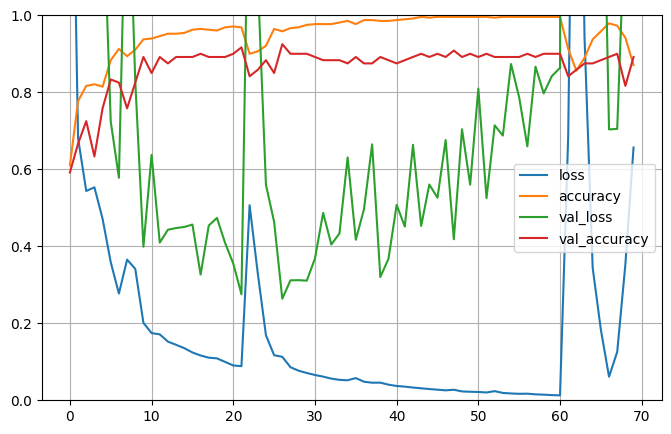

In [236]:
import pandas as pd
import matplotlib.pyplot as plt

history_df = pd.DataFrame(history.history)
history_df.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [237]:
model.evaluate(x_test_scaled, y_test)

5/5 [==============================] - 0s 5ms/step - loss: 0.4583 - accuracy: 0.9133


[0.45827266573905945, 0.9133333563804626]

In [238]:
preds = model.predict(x_test_scaled)

5/5 [==============================] - 0s 3ms/step


In [239]:
y_test

array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1])

In [240]:
preds = (preds >= 0.5)

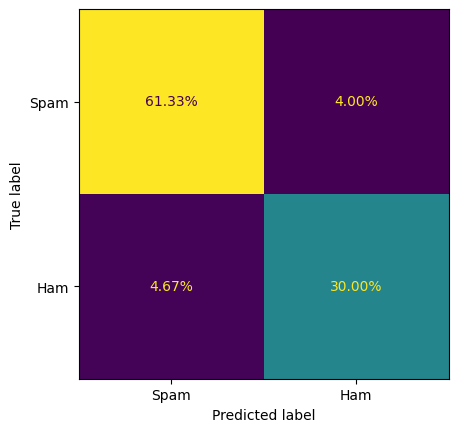

In [241]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt

cm = ConfusionMatrixDisplay(
    confusion_matrix(
        y_true=y_test,
        y_pred=preds,
        normalize='all'
    ),
    display_labels=['Spam', 'Ham'],
)

# Plot the confusion matrix with specified formatting
cm.plot(
    values_format='.2%',  # Display values as percentages with two decimal places
    colorbar=False,  # Do not display the color bar
)

# Display the confusion matrix plot
plt.show()

In [242]:
model.save("spam_clf.keras")